In [7]:
import pandas as pd

#from collections import defaultdict
import matplotlib.pyplot as plt
#from datetime import datetime as dt
#from scipy.signal import lfilter


import graphs.processData as prd


In [3]:
plt.rcParams['font.family'] = 'Gill Sans MT'
plt.rcParams["font.size"] = 18

In [4]:
#For PPTs
plt.rcParams["text.color"] = 'white'

## Process meassurements -----------------------------

In [9]:
#flow meter file
flowDataCsv = '01-Data/03-FlowmeterData/01-FlowrateMeassurements.csv'

dfFlowsm3h = prd.processMeassuredData(flowDataCsv)

#cuts the flow
dfFlowsm3hDWF = dfFlowsm3h[(dfFlowsm3h.index >= pd.to_datetime("2022-06-19 00:00:00"))&(dfFlowsm3h.index < pd.to_datetime("2022-06-22 00:00:00"))]


# Model data ----------------------------------------------------------

In [7]:
#Names created here
STSACRA_TO_LIMOLIOU = "StSacraLimoliou"
PASCAL = "Pascal"
WTP = "WTP"

MOD_SUFFIX = ' (m3/h) MODEL' 

# WEST DATA ------------------

In [9]:
#Names created here
WTP_WEST = "WTP WEST"
NO_WEST = "NO"
STSACREMENT_WEST = "St-Sacrement"
BEAUPORT_WEST = "Beauport"

UNITS_FLOW = ' (m3/d)'
UNITS_GRAPH_FLOW = ' (m3/h)'


#WEST model names
TIME_WEST ='#.t'
STATION_EST_WEST = ".Qin_GC.Q_In" 
ST_SACREMENT_CATCH_WEST = ".Sew_1.Q_In" 
NO_CATCH_WEST = ".Sew_33.Q_In" #Catchment
STSACRE_B4_LIMOLIOU_WEST = ".Sew_90.Q_Out"  #all before limoilou leg
UPSTREAM_LIMOLIOU_WEST = ".Well_18.Q_Out" # limoilou leg
STSACRE_TO_LIMOLIOU_WEST = ".Well_20.Q_In1" # all incluided limoilou
BEAUPORT = ".Well_20.Q_In2" # beauport



In [10]:
startDate = dfFlowsm3hDWF.index[0]
endDate = dfFlowsm3hDWF.index[-1]

In [11]:
def getDFWESTResults(WEST_WTP_csv,dateIni,dateFin,WTPName):

    WTP_WEST_Results = pd.read_csv(WEST_WTP_csv, delimiter = ',')

    WTP_WEST_Results[TIME_WEST] = WTP_WEST_Results[TIME_WEST]-WTP_WEST_Results[TIME_WEST].min()  #Coz i started the simulation on day 5 
    
    # Convert the "Days" column to timedelta objects (days) and calcualte the date base on the starting date 
    startDatetime = pd.to_datetime(startDate)
    endDatetime = pd.to_datetime(endDate)
    WTP_WEST_Results[TIME_WEST] = pd.to_timedelta(WTP_WEST_Results[TIME_WEST], unit='D')
    WTP_WEST_Results['Date'] = dateIni + WTP_WEST_Results[TIME_WEST] 
    
    WTP_WEST_ResultsCut= WTP_WEST_Results[WTP_WEST_Results['Date']< dateFin]
    WTP_WEST_ResultsCut = WTP_WEST_ResultsCut.drop(columns=[TIME_WEST]).set_index('Date')

    WTP_WEST_ResultsCut.rename(columns={WTPName:WTP_WEST+UNITS_FLOW,NO_CATCH_WEST:NO_WEST+UNITS_FLOW},inplace=True)
    
    # pass from m3/d to m3/h
    for column in WTP_WEST_ResultsCut.columns:
        new_column_name = column.replace('(m3/d)', '(m3/h)')
        WTP_WEST_ResultsCut[new_column_name] = WTP_WEST_ResultsCut[column] /24
        WTP_WEST_ResultsCut.drop(columns=[column],inplace=True)

    return WTP_WEST_ResultsCut
    

In [12]:
#WEST_WTP_csv = '01-Data/07-WESTFlowEST.csv'
WEST_WTP_csv = '01-Data/03-ResultsOldWESTModel(DWF)/02-WESTFlowResults.csv'
dfWEST_Results = getDFWESTResults(WEST_WTP_csv,startDate,endDate,STATION_EST_WEST)


# Comparisons -----

In [13]:
def plotComparisonsWEST(measured, westOriginal, west, figName,colors):

    #plots the series of each column
    fig1, ax  = plt.subplots(figsize=(14,6)); #creates the figure

    measured.plot(ax=ax, alpha=0.8, marker='.', linewidth=0, color=colors[0]);
    
    westOriginal.plot(ax=ax, alpha=0.8, linewidth=2, ls='--', color=colors[1]);

    west.plot(ax=ax, alpha=0.8, linewidth=2, color= colors[2]);
    
    ax= modifyForPpt(ax)
        
    ax.set_ylabel("Flow rate (m³/h)")
    
    ax.legend(ncol=3,loc='upper center',bbox_to_anchor=(.45,-.22), framealpha=0);#puts the figure in the bottom center with 4 col
    removeTopRightFrame(ax)

    fig1.savefig('03-Graphs/'+'Comparison'+figName+'.png', dpi=200, bbox_inches='tight',transparent=True); #saves the fig
   
   

In [14]:
STATION_EST_WEST_MANUAL = '.Well_9.Q_Out'

WEST_WTP_Manual_csv = '01-Data/04-ResultsManualOldWESTModel/05-ResultsBPWithInfiltration.csv'

dfWEST_Manual_Results = getDFWESTResults(WEST_WTP_Manual_csv,startDate,endDate,STATION_EST_WEST_MANUAL)

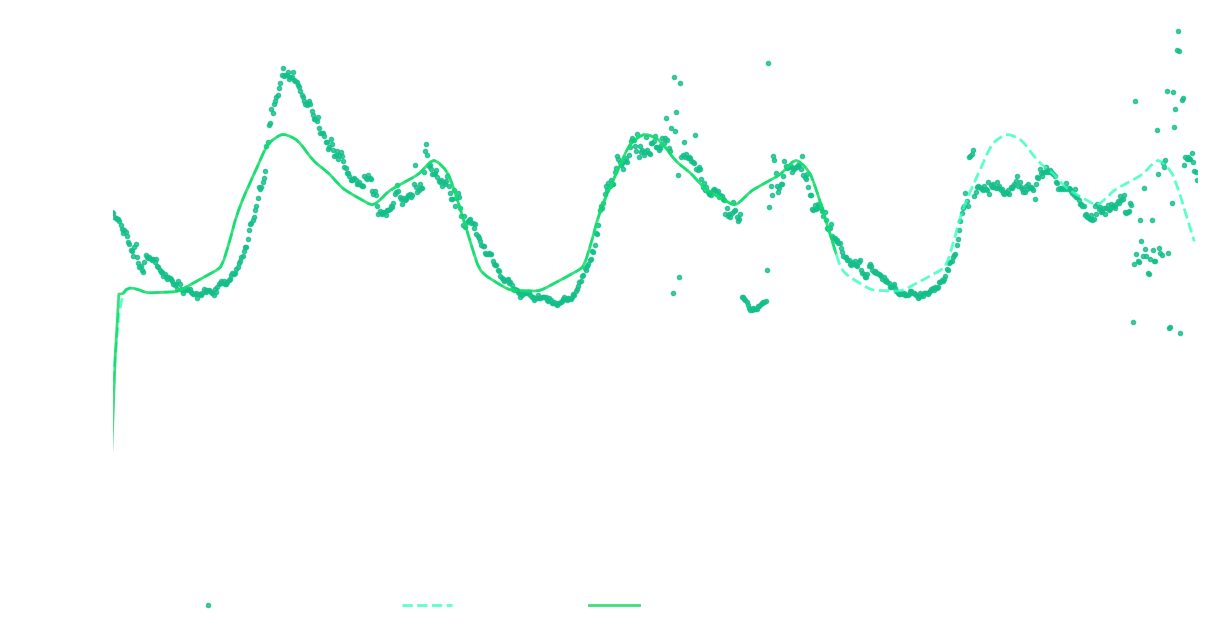

In [15]:
measured = dfFlowsm3hDWF[[ESTA_ME]].copy()
measured.rename(columns={measured.columns[0]:"Measured"},inplace=True)

westOriginal = dfWEST_Results[[WTP_WEST+" (m3/h)"]].copy()
westOriginal.rename(columns={westOriginal.columns[0]:"Legacy"},inplace=True)

westManual = dfWEST_Manual_Results[[WTP_WEST+" (m3/h)"]].copy()
westManual.rename(columns={westManual.columns[0]:"Basic Parameters & 0.25 Infiltration"},inplace=True)

plotComparisonsWEST(measured,westOriginal,westManual,"BasicParametersInfiltra",[EST_C,EST_C2,EST_C3])

In [23]:
STATION_EST_WEST_MANUAL = '.Qin_GC.Q_In'

WEST_WTP_OLDModified_csv = '01-Data/03-ResultsOldWESTModel(DWF)/05-WESTFlowResults(modifiedkto2).csv'

dfWEST_Manual_Results = getDFWESTResults(WEST_WTP_OLDModified_csv,startDate,endDate,STATION_EST_WEST_MANUAL)

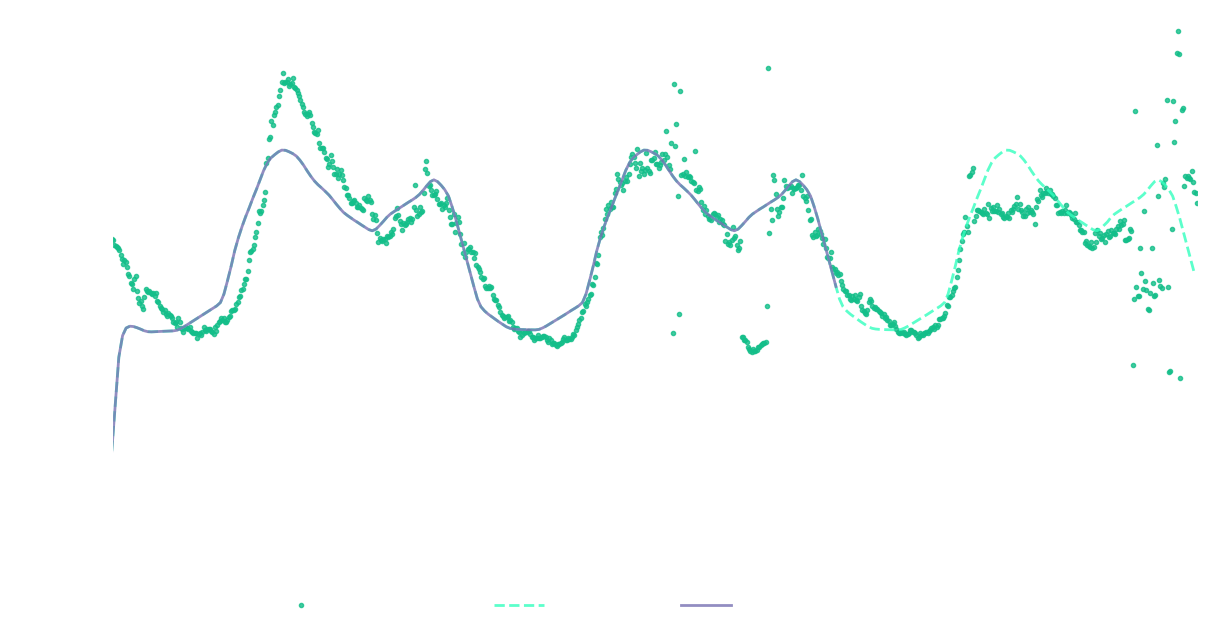

In [24]:
measured = dfFlowsm3hDWF[[ESTA_ME]].copy()
measured.rename(columns={measured.columns[0]:"Measured"},inplace=True)

westOriginal = dfWEST_Results[[WTP_WEST+" (m3/h)"]].copy()
westOriginal.rename(columns={westOriginal.columns[0]:"Legacy"},inplace=True)

westManual = dfWEST_Manual_Results[[WTP_WEST+" (m3/h)"]].copy()
westManual.rename(columns={westManual.columns[0]:"Basic Parameters"},inplace=True)

plotComparisonsWEST(measured,westOriginal,westManual,"BasicParameters",[EST_C,EST_C2,BEAU_C])